In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 30.9 MB/s 
     |████████████████████████████████| 115 kB 50.2 MB/s 
     |████████████████████████████████| 212 kB 76.7 MB/s 
     |████████████████████████████████| 120 kB 68.1 MB/s 
     |████████████████████████████████| 127 kB 71.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 48.8 MB/s 


In [ ]:
from transformers import BertForSequenceClassification,BertModel,BertTokenizer,BertConfig,AdamW,get_linear_schedule_with_warmup
from datasets import load_dataset
import torch 
import nltk 
import pandas as pd
from urllib.request import urlretrieve
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm,trange
import io 
import numpy as np
import matplotlib.pyplot as plt





In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print('we have : {0} {1} gpus available'.format(n_gpu,torch.cuda.get_device_name(0)))

we have : 1 Tesla T4 gpus available


In [ ]:
!wget https://raw.githubusercontent.com/Damilola-ops/Transformers-for-Natural-Language-Processing/main/Chapter02/in_domain_train.tsv
!wget https://raw.githubusercontent.com/Damilola-ops/Transformers-for-Natural-Language-Processing/main/Chapter02/out_of_domain_dev.tsv

--2022-08-31 15:04:42--  https://raw.githubusercontent.com/Damilola-ops/Transformers-for-Natural-Language-Processing/main/Chapter02/in_domain_train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438726 (428K) [text/plain]
Saving to: ‘in_domain_train.tsv’

in_domain_train.tsv 100%[===================>] 428.44K  --.-KB/s    in 0.004s  

2022-08-31 15:04:43 (105 MB/s) - ‘in_domain_train.tsv’ saved [438726/438726]

--2022-08-31 15:04:43--  https://raw.githubusercontent.com/Damilola-ops/Transformers-for-Natural-Language-Processing/main/Chapter02/out_of_domain_dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

In [ ]:
data = pd.read_csv('/content/in_domain_train.tsv', delimiter='\t',header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
data.shape

(8551, 4)

In [ ]:
data[10:14]


,sentence_source,label,label_notes,sentence
10,gj04,1,NaN,the critics laughed the play off the stage .
11,gj04,1,NaN,the pond froze solid .
12,gj04,1,NaN,bill rolled out of the room .
13,gj04,1,NaN,the gardener watered the flowers flat .


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_Case=True)

In [ ]:
sentences = data.sentence.values

In [ ]:
labels = data.label.values

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print('tokenize the first sentence:')
print(tokenized_texts[0])

tokenize the first sentence:
['our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']


In [ ]:
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)


In [ ]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:

batch_size = 32
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
configuration = BertConfig()
model_scratch = BertModel(configuration)
configuration = model_scratch.config 
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias','LayerNorm.weight']
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
param_optimizer

In [ ]:
#optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat==labels_flat) / len(labels_flat)

In [ ]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
       logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.586346249610062


Epoch:  25%|██▌       | 1/4 [02:32<07:36, 152.07s/it]

Validation Accuracy: 0.7361111111111112
Train loss: 0.4799506921491188


Epoch:  50%|█████     | 2/4 [05:06<05:07, 153.52s/it]

Validation Accuracy: 0.7600308641975309
Train loss: 0.3680909957381205


Epoch:  75%|███████▌  | 3/4 [07:41<02:34, 154.11s/it]

Validation Accuracy: 0.78125
Train loss: 0.28852785746586274


Epoch: 100%|██████████| 4/4 [10:16<00:00, 154.03s/it]

Validation Accuracy: 0.7870370370370371


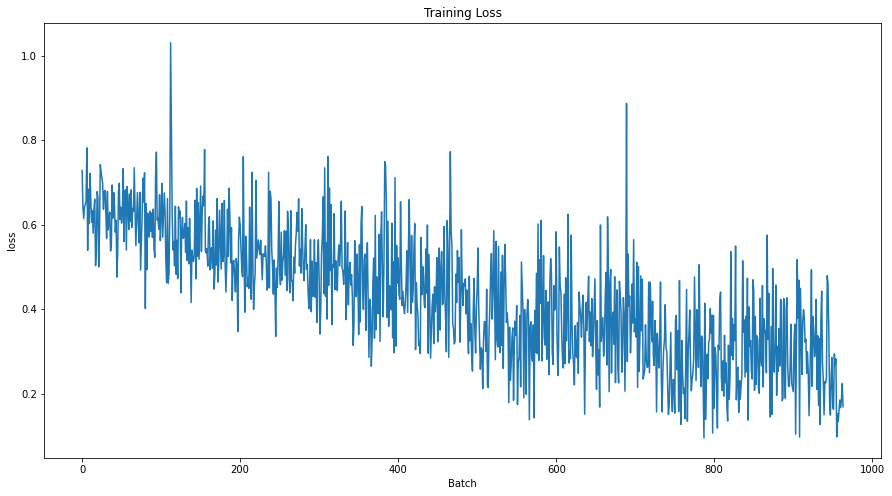

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('loss')
plt.plot(train_loss_set)
plt.show()

In [ ]:
df = pd.read_csv("/content/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
from sklearn.metrics import matthews_corrcoef

In [ ]:
matthews_set = []

In [ ]:
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],np.argmax(predictions[i],axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
matthews_set

[0.08818077954471167,
 -0.1773241389867146,
 0.22267206477732793,
 0.16005781417779466,
 0.2548235957188128,
 0.6494848686351458,
 0.23329882422520506,
 0.09759000729485333,
 0.4700159919404217,
 0.5875955600576714,
 0.45273496010290487,
 0.21821789023599236,
 0.34470668367478197,
 0.17910620335162064,
 0.19432508268938872,
 0.374943053707453,
 -0.3333333333333333]

In [ ]:

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.2677555825071331

In [ ]:
trial_data = dict()
trial_data['sentences'] = sentences

In [ ]:
len(trial_data['sentences'])

In [ ]:
#adding CLS and SEP tokens for BERT
sentences = ['[CLS]' + sentence + '[SEP]' for sentence in sentences]

In [ ]:
max_text_length = 128
def tokenize(text):
  input_id = tokenizer(data['sentences'],padding="max_length", truncation=True, max_length=max_text_length).input_ids
  attention_mask = tokenizer(data['sentences'],padding="max_length", truncation=True, max_length=max_text_length).attention_mask
  text['input_ids'] = input_id
  text['attention_masks'] = attention_mask
  return text

In [ ]:
tokenized_trial_data = tokenize(trial_data) 

In [ ]:
sentences[0]

In [ ]:
trial_data['sentences'][0]

In [ ]:
#checking to see if I messed up  anything 
a = tokenizer(sentences[0]).input_ids
b = tokenized_trial_data['input_ids'][0]
assert 'a == b '